In [ ]:
!pip install quantecon
!pip install numba
!pip install interpolation

# Aiyagari に従って...

In [78]:
# パラメータ
beta = 0.96
gamma = 3.0
rho = 0.6
sigma = 0.4
alpha = 0.36
delta = 0.08
b = 3.0

In [79]:
# (1 / beta) - 1

0.04166666666666674

In [110]:
r0 = 0.03
K0d = ((r0 + delta) / alpha) ** (1 / (alpha - 1))
w0 = (1 - alpha) * (K0d ** alpha)
print(w0)

1.246857279797728


## 政策関数...

In [116]:
# 解く問題の設定を行う（パラメータ, グリッド, 効用関数や生産関数）
# モデルを変更する場合にはここを修正
class Setting:

    def __init__(self,
                 R=1.01,                          # 粗実質利子率
                 beta=0.99,                          # 割引因子
                 gamma=1,                          # 相対的リスク回避度(異時点間の代替弾力性の逆数)
                 b=0,                             # 内生的な状態変数の最小値, 借入制約
                 a_max=16,                        # 内生的な状態変数の最大値
                 na=21,                           # 内生的な状態変数のグリッド数
                 mu=0,                            # 外生変数のAR(1)過程の定数項
                 rho=0.6,                        # 外生変数のAR(1)過程の慣性
                 sigma=0.4,                       # 外生変数のAR(1)過程のショック項の標準偏差
                 nz = 11,                         # 外生変数のグリッド数
                 w = 0,                         # 賃金
                 lambdaPF = 1):                 # 政策関数の更新度

        # パラメータを設定する
        self.R = R
        self.beta = beta
        self.b = b
        self.gamma = gamma

        # 外生変数の遷移確率とグリッドを設定する
        mc = rouwenhorst(nz, rho, sigma, mu)
        self.Pz = mc.P
        self.z_grid = np.exp(mc.state_values)

        # 内生的な状態変数のグリッドを設定する
        a_grid = np.linspace(-b, a_max, na)
        self.a_grid = a_grid

        # 賃金を設定
        self.w = w

        # 政策関数の更新度を設定する
        self.lambdaPF = lambdaPF

        # CRRA型効用関数と限界効用を定義する
        gamma = self.gamma
        if gamma == 1:
            self.utility = np.log
            self.mutility = njit(lambda x: 1 / x)
        else:
            self.utility = njit(lambda x: x**(1-gamma) / (1 - gamma))
            self.mutility = njit(lambda x: x**(-gamma))


		    # 政策関数の初期値を定義する
        z_grid = self.z_grid
        hfun_old = np.empty((len(a_grid), len(z_grid)))
        for i_a, a in enumerate(a_grid):
            for i_z, z in enumerate(z_grid):
                c_max = 0.5* (R * a + z + b)
                hfun_old[i_a, i_z] = c_max
        self.hfun_old = hfun_old


# 特定のアルゴリズムを実行して政策関数を更新する関数を出力する
# FOCを変更する場合やアルゴリズムを変更する場合はここを修正

# 今期の状態変数について繰り返し記号はi, 来期の状態変数について繰り返し記号はj

def TimeIteration(hp): # hpはSettingクラスからつくられるインスタンス

    # インスタンスからローカル変数を定義する
    R, beta, b, mutility, w = hp.R, hp.beta, hp.b, hp.mutility, hp.w
    a_grid, z_grid, Pz = hp.a_grid, hp.z_grid, hp.Pz

    @njit
    def FOCs(c, a, z, i_z, hfun):

        # 制約式から次期の内生的な状態変数を計算する
        aprime = R * a + w*z - c

        expectation = 0
        for j_z in range(len(z_grid)):
            # 政策関数の候補を補間して次期の制御変数を計算する
            cprime = interp(a_grid, hfun[:, j_z], aprime)

            # オイラー方程式の右辺を計算する
            expectation += mutility(cprime) * Pz[i_z, j_z]

        rhs = max(R * beta * expectation, mutility(R * a + w*z + b))

        FOC_diff = mutility(c) - rhs

        return FOC_diff


    @njit
    def UpdatePF(h_old):

        h_new = np.empty_like(h_old)
        for i_a in range(len(a_grid)):
            a = a_grid[i_a]
            for i_z in range(len(z_grid)):
                z = z_grid[i_z]
                c_star = brentq(FOCs, 1e-8, R * a + w*z + b, args=(a, z, i_z, h_old)).root
                h_new[i_a, i_z] = c_star

        return h_new

    return UpdatePF





# メイン関数：特定のアルゴリズムでiterationを行い、問題を解く関数
# 基本的には変更する必要がない

def SolveProblem(hp,               # Settingクラスからつくられるインスタンス
                Algorithm,         # アルゴリズムを指定
                tol=1e-4,          # 許容繰り返し誤差
                max_iter=10000,     # iteration回数の最大値
                verbose=True,      # 進捗を表示するかどうか
                print_skip=25):    # 進捗を何回ごとに表示するか


    # インスタンスからローカル変数を定義する
    R, beta, b, mutility = hp.R, hp.beta, hp.b, hp.mutility
    a_grid, z_grid, Pz = hp.a_grid, hp.z_grid, hp.Pz
    lambdaPF = hp.lambdaPF
    hfun_old = hp.hfun_old

    # チェックのために外生変数のグリッドと遷移確率を表示する
    # print(f"About exogenous variables:")
    # print(f"grid is {z_grid}.")
    # print(f"Transition matrix is {Pz}.")



    # 政策関数を更新する関数を取得する
    UpdatePF = Algorithm(hp)

    # iterationを行い、問題を解く
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:

        # 政策関数を更新する
        hfun_new_tilde = UpdatePF(hfun_old)

        # 古い政策関数と加重平均する
        hfun_new = lambdaPF*hfun_new_tilde + (1-lambdaPF)*hfun_old

        error = np.max(np.abs(hfun_new-hfun_old))
        i += 1
        if verbose and i % print_skip == 0:      # 進捗をprint_skip回ごとに表示する
            print(f"Error at iteration {i} is {error}.")
        hfun_old = hfun_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return hfun_new

In [103]:
hp = Setting(beta=beta, gamma = gamma, b = b, lambdaPF = 1, na = 100, nz = 10, rho = rho, sigma = sigma, R = 1 + r0, w = w0)
hfun_c = SolveProblem(hp,TimeIteration)

<ipython-input-88-ff7cbfab246f>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


About exogenous variables:
grid is [0.22313016 0.31140322 0.43459821 0.60653066 0.84648172 1.18136041
 1.64872127 2.30097589 3.21127054 4.48168907].
Transition matrix is [[1.34217728e-01 3.01989888e-01 3.01989888e-01 1.76160768e-01
  6.60602880e-02 1.65150720e-02 2.75251200e-03 2.94912000e-04
  1.84320000e-05 5.12000000e-07]
 [3.35544320e-02 2.01326592e-01 3.27155712e-01 2.64241152e-01
  1.26615552e-01 3.85351680e-02 7.56940800e-03 9.33888000e-04
  6.60480000e-05 2.04800000e-06]
 [8.38860800e-03 8.17889280e-02 2.62668288e-01 3.27548928e-01
  2.14007808e-01 8.27473920e-02 1.97406720e-02 2.86771200e-03
  2.33472000e-04 8.19200000e-06]
 [2.09715200e-03 2.83115520e-02 1.40378112e-01 3.09460992e-01
  3.03685632e-01 1.58773248e-01 4.79892480e-02 8.46028800e-03
  8.11008000e-04 3.27680000e-05]
 [5.24288000e-04 9.04396800e-03 6.11450880e-02 2.02457088e-01
  3.34768128e-01 2.59686912e-01 1.05848832e-01 2.36421120e-02
  2.75251200e-03 1.31072000e-04]
 [1.31072000e-04 2.75251200e-03 2.36421120e-0

## 定常分布...

In [104]:
import numpy as np
from typing import Callable

# TODO: 定常分布が政策関数と同じ要素数であることを前提としてしまっている

# 政策関数によって得られたグリッド外の値が、グリッド上に移動する確率行列を計算する関数
@njit
def split_prob_to_agrid(aprime: float, agrid: np.ndarray) -> np.ndarray:
    """ 政策関数によって得られた a の値が、a_grid のどの点に移動するのかを示す確率ベクトルを計算する関数

    Args:
    aprime: 政策関数によって得られた a の値
    agrid: a のグリッド
    return: aprime が agrid のどの点に移動するのかを示す確率ベクトル
    """
    probs = np.zeros(len(agrid))
    # a の値が a_grid の最小値より小さい場合
    if aprime <= agrid[0]:
        probs[0] = 1.0
        return probs

    # a の値が a_grid の最大値より大きい場合
    if aprime >= agrid[-1]:
        probs[-1] = 1.0
        return probs

    # a の値が a_grid の最小値より大きく最大値より小さい場合
    for i in range(len(agrid)-1):
        if agrid[i] <= aprime <= agrid[i+1]:
            probs[i] = (agrid[i+1] - aprime) / (agrid[i+1] - agrid[i])
            probs[i+1] = (aprime - agrid[i]) / (agrid[i+1] - agrid[i])
            return probs

    # この行までに return されていない場合はエラーを出す
    raise ValueError("Splitting probability failed.")

@njit
def calc_weight_matrix(aprime_grid: np.ndarray, agrid: np.ndarray, split_prob_to_agrid = split_prob_to_agrid) -> np.ndarray:
    """ 前期の定常分布に係る重みづけ確率行列 weight_matrix を計算する関数

    Args:
        aprime_grid: 政策関数の行き先のグリッド
        agrid: 資産のグリッド
        split_prob: 政策関数によって得られた a の値が、a_grid のどの点に移動するのかを示す確率ベクトルを計算する関数

    Returns:
        weight_matrix: 前期の定常分布に係る重みづけ確率のグリッド、shape は aprime_grid と同じ
    """
    weight_matrix = np.empty((len(aprime_grid), len(aprime_grid[0]), len(agrid)))

    # aprime_grid は 二次元配列
    for i in range(len(aprime_grid)):
        for j in range(len(aprime_grid[0])):
            weight_matrix[i, j] = split_prob_to_agrid(float(aprime_grid[i, j]), agrid)
    return weight_matrix

@njit
def gen_pmesh(aprime_grid: np.ndarray, P: np.ndarray, next_y_index: int) -> np.ndarray:
    """ 遷移確率を 政策関数 aprime_grid との要素ごとの計算に使えるように meshgrid を生成する関数

    Args:
        aprime_grid (np.ndarray): 政策関数のグリッド
        P (np.ndarray): 遷移確率行列
        next_y_index (int): 次期の所得状態 y' のインデックス

    Returns:
        np.ndarray: 政策関数と遷移確率行列を使って計算するための meshgrid
    """
    pmesh = np.zeros(aprime_grid.shape)
    for i in range(len(aprime_grid)):
        for j in range(len(aprime_grid[0])):
            pmesh[i, j] = P[j, next_y_index]
    return pmesh

# def calc_sd_point(Pmesh, weight, sd_old) -> float:
#     """ 定常分布の一点を計算する関数

#     Args:
#         Pmesh (np.ndarray): 政策関数と遷移確率行列を使って計算した meshgrid
#         weight (np.ndarray): 前期の定常分布に係る重みづけ確率
#         sd_old (np.ndarray): 一期前の定常分布 f(a, y)

#     Returns:
#         float: 更新された(次期の)定常分布の一点の値
#     """
#     return np.sum(Pmesh * weight * sd_old)

@njit
def update_sd(aprime_grid: np.ndarray, agrid: np.ndarray, sd_old: np.ndarray, P: np.ndarray,
            split_prob_to_agrid = split_prob_to_agrid, calc_weight_matrix = calc_weight_matrix,
            gen_P = gen_pmesh,
            # calc_sd_point = calc_sd_point
            ) -> np.ndarray:
    """ 定常分布を更新する関数

    Args:
        aprime_grid (np.ndarray): 政策関数のグリッド
        agrid (np.ndarray): 資産のグリッド
        sd_old (np.ndarray): 更新前の定常分布
        P (np.ndarray): 遷移確率行列
        split_prob (Callable): 政策関数によって得られた a の値が、a_grid のどの点に移動するのかを示す確率ベクトルを計算する関数
        calc_weight (Callable): 前期の定常分布に係る重みづけ確率 weight を計算する関数
        gen_P (Callable): 遷移確率を 政策関数 aprime_grid との要素ごとの計算に使えるように meshgrid を生成する関数
        calc_sd_point (Callable): 定常分布の一点を計算する関数

    Returns:
        sd_new（np.ndarray）: 更新された定常分布のグリッド
    """
    sd_new = np.zeros(sd_old.shape)
    weight_matrix = calc_weight_matrix(aprime_grid, agrid, split_prob_to_agrid)
    for i in range(len(aprime_grid)):
        for j in range(len(aprime_grid[0])):
            p_mesh = gen_P(aprime_grid, P, j)
            # sd_new[i, j] = calc_sd_point(p_mesh, weight_matrix[:,:,i], sd_old)
            sd_new[i,j] = np.sum(p_mesh * weight_matrix[:,:,i] * sd_old)

    return sd_new

@njit
def sd_iteration(sd0: np.ndarray, aprime_grid: np.ndarray, agrid: np.ndarray, P: np.ndarray,
                        tol: float = 1e-6, max_iter: int = 1000,
                        update_sd = update_sd) -> np.ndarray:
    """ 定常分布を計算する関数

    Args:
        aprime_grid (np.ndarray): 政策関数のグリッド
        agrid (np.ndarray): 資産のグリッド
        guess_sd (np.ndarray): 初期の定常分布のグリッド
        P (np.ndarray): 遷移確率行列
        tol (float, optional): 許容する誤差. Defaults to 1e-6.
        max_iter (int, optional): 最大の反復回数. Defaults to 1000.
        update_sd (_type_, optional): 定常分布を更新する関数. Defaults to update_sd.

    Returns:
        np.ndarray: 収束した定常分布のグリッド
    """
    sd_old = sd0

    diff = tol + 1
    iteration = 0
    while diff > tol and iteration < max_iter:
        sd_new = update_sd(aprime_grid, agrid, sd_old, P)
        diff = np.max(np.abs(sd_new - sd_old))
        sd_old = sd_new
        iteration += 1
        # print(f"Iteration {iteration}: diff = {diff}")

    # 最終イタレーション回数の出力
    print(f"Total iterations until convergence: {iteration}")

    # 定常分布の出力
    # print("Stationary distribution f_{i,j}:")
    # print(sd_new)
    return sd_new


In [105]:
# hfun_c から 時期のアセット aの政策関数を求める
hfun_aprime = np.empty((len(hp.a_grid), len(hp.z_grid)))
a_mesh, z_mesh = np.meshgrid(hp.a_grid, hp.z_grid, indexing='ij') # ユニバーサル関数を使用するためのグリッドを生成
hfun_aprime = hp.R * a_mesh + hp.w * z_mesh - hfun_c

# 初期の定常分布を定義
sd_grid = np.full(hfun_aprime.shape, 1/hfun_aprime.size)

In [106]:
sd = sd_iteration(sd_grid, hfun_aprime, hp.a_grid, hp.Pz)

Total iterations until convergence: 150


In [113]:
Amesh, _ = np.meshgrid(hp.a_grid, hp.z_grid, indexing='ij')
A0 = np.sum(Amesh * sd)

print(A0)

6.5789426695331406


## 実際に反復

In [120]:
r0 = 0.03

diff = 1
loop = 0
while abs(diff) > 1e-6:
    loop += 1
    print("loop: ", loop)
    # 1
    K0d = ((r0 + delta) / alpha) ** (1 / (alpha - 1))
    w0 = (1 - alpha) * (K0d ** alpha)

    # 2
    hp = Setting(beta=beta, gamma = gamma, b = b, lambdaPF = 1, na = 20, nz = 3, rho = rho, sigma = sigma, R = 1 + r0, w = w0)
    hfun_c = SolveProblem(hp,TimeIteration)

    # 3
    # hfun_c から 時期のアセット aの政策関数を求める
    hfun_aprime = np.empty((len(hp.a_grid), len(hp.z_grid)))
    a_mesh, z_mesh = np.meshgrid(hp.a_grid, hp.z_grid, indexing='ij') # ユニバーサル関数を使用するためのグリッドを生成
    hfun_aprime = hp.R * a_mesh + hp.w * z_mesh - hfun_c

    # 初期の定常分布を定義
    sd_grid = np.full(hfun_aprime.shape, 1/hfun_aprime.size)

    sd = sd_iteration(sd_grid, hfun_aprime, hp.a_grid, hp.Pz)

    # 4
    Amesh, _ = np.meshgrid(hp.a_grid, hp.z_grid, indexing='ij')
    A0 = np.sum(Amesh * sd)
    print("A0: ", A0)
    diff = (A0 - K0d)
    print("diff: ", diff)

    r0 = r0 - 0.001 * diff

r0 = r0 + 0.001 * diff

loop:  1


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02820329125935661.
Error at iteration 50 is 0.004900033188066644.
Error at iteration 75 is 0.001320575761877496.
Error at iteration 100 is 0.0003990468177188511.
Error at iteration 125 is 0.00012386476035119998.

Converged in 130 iterations.
Total iterations until convergence: 160
A0:  7.103433279911293
diff:  0.7274585536729123
loop:  2


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.028051008453428672.
Error at iteration 50 is 0.004778295509547892.
Error at iteration 75 is 0.0012479623278156549.
Error at iteration 100 is 0.00036044435482818216.
Error at iteration 125 is 0.00010705606212590979.

Converged in 127 iterations.
Total iterations until convergence: 100
A0:  6.827983944589141
diff:  0.3855622098103817
loop:  3


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02796898810469184.
Error at iteration 50 is 0.004713755961271104.
Error at iteration 75 is 0.0012105921433089861.
Error at iteration 100 is 0.00034151886211164495.
Error at iteration 125 is 9.8613536700487e-05.

Converged in 125 iterations.
Total iterations until convergence: 97
A0:  6.69565099368859
diff:  0.21754967677464787
loop:  4


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02792229644923072.
Error at iteration 50 is 0.00467733398875092.
Error at iteration 75 is 0.0011898427927028443.
Error at iteration 100 is 0.0003316394016747992.

Converged in 124 iterations.
Total iterations until convergence: 119
A0:  6.61867076438103
diff:  0.12029433814297619
loop:  5


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02789634883051617.
Error at iteration 50 is 0.004657194608052695.
Error at iteration 75 is 0.0011784730396109389.
Error at iteration 100 is 0.000326285660794845.

Converged in 124 iterations.
Total iterations until convergence: 127
A0:  6.576705332102532
diff:  0.06707303690032873
loop:  6


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02788184108377667.
Error at iteration 50 is 0.0046459631448767524.
Error at iteration 75 is 0.001172165234557987.
Error at iteration 100 is 0.0003233338479244896.

Converged in 124 iterations.
Total iterations until convergence: 131
A0:  6.553402959994284
diff:  0.03748078958009948
loop:  7


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027873721560614406.
Error at iteration 50 is 0.004639686384002584.
Error at iteration 75 is 0.0011686502640211316.
Error at iteration 100 is 0.0003216946673969545.

Converged in 123 iterations.
Total iterations until convergence: 133
A0:  6.539672563987228
diff:  0.020231233669778526
loop:  8


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.0278693351024768.
Error at iteration 50 is 0.004636298230744185.
Error at iteration 75 is 0.0011667559084793666.
Error at iteration 100 is 0.00032081293261732036.

Converged in 123 iterations.
Total iterations until convergence: 134
A0:  6.532691823303977
diff:  0.0113496390963288
loop:  9


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027866873170304896.
Error at iteration 50 is 0.004634397502076837.
Error at iteration 75 is 0.0011656940894146928.
Error at iteration 100 is 0.00032031921084207937.

Converged in 123 iterations.
Total iterations until convergence: 134
A0:  6.5288476298349645
diff:  0.006438676375982055
loop:  10


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027865476143791312.
Error at iteration 50 is 0.004633319218020127.
Error at iteration 75 is 0.0011650920065959802.
Error at iteration 100 is 0.000320039418148399.

Converged in 123 iterations.
Total iterations until convergence: 134
A0:  6.526668039395375
diff:  0.0036537780501735284
loop:  11


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027864683250192535.
Error at iteration 50 is 0.0046327073216119175.
Error at iteration 75 is 0.0011647504338001546.
Error at iteration 100 is 0.00031988074164934766.

Converged in 123 iterations.
Total iterations until convergence: 134
A0:  6.525431576636579
diff:  0.0020737781476327655
loop:  12


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02786423318880482.
Error at iteration 50 is 0.004632360041162187.
Error at iteration 75 is 0.001164556591686683.
Error at iteration 100 is 0.0003197907094001362.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.52460462936346
diff:  0.001051835984029914
loop:  13


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027864004903727757.
Error at iteration 50 is 0.004632183901337683.
Error at iteration 75 is 0.0011644582805310222.
Error at iteration 100 is 0.00031974505213550053.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.524248603150133
diff:  0.0005969032314334655
loop:  14


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027863875351766598.
Error at iteration 50 is 0.004632083944313248.
Error at iteration 75 is 0.0011644024926904528.
Error at iteration 100 is 0.0003197191447905645.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.524046573486375
diff:  0.0003387443000848478
loop:  15


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.0278638018296391.
Error at iteration 50 is 0.004632027218421708.
Error at iteration 75 is 0.0011643708337678582.
Error at iteration 100 is 0.000319704443175306.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523931924479811
diff:  0.00019224142050422444
loop:  16


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02786376010463254.
Error at iteration 50 is 0.004631995025810021.
Error at iteration 75 is 0.0011643528672022896.
Error at iteration 100 is 0.0003196960999800602.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.52386686090008
diff:  0.00010910027539878797
loop:  17


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02786373642487172.
Error at iteration 50 is 0.004631976755952838.
Error at iteration 75 is 0.001164342670931795.
Error at iteration 100 is 0.00031969136522924657.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523829936565225
diff:  6.191657822451901e-05
loop:  18


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027863722986106954.
Error at iteration 50 is 0.004631966387449005.
Error at iteration 75 is 0.001164336884406314.
Error at iteration 100 is 0.0003196886781771102.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523808981384516
diff:  3.513899338969395e-05
loop:  19


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02786371535930421.
Error at iteration 50 is 0.0046319605030991085.
Error at iteration 75 is 0.0011643336004381055.
Error at iteration 100 is 0.0003196871532002987.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523797088904775
diff:  1.9942169956266298e-05
loop:  20


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.02786371103092211.
Error at iteration 50 is 0.004631957163597544.
Error at iteration 75 is 0.0011643317366720751.
Error at iteration 100 is 0.00031968628778011876.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.52379033966624
diff:  1.1317640749908264e-05
loop:  21


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027863708574464408.
Error at iteration 50 is 0.004631955268352694.
Error at iteration 75 is 0.0011643306789905772.
Error at iteration 100 is 0.0003196857966485389.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523786509321428
diff:  6.423024899504526e-06
loop:  22


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027863707180367125.
Error at iteration 50 is 0.004631954192757082.
Error at iteration 75 is 0.0011643300787147481.
Error at iteration 100 is 0.0003196855178901892.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523784335513457
diff:  3.6452181824131458e-06
loop:  23


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027863706389178233.
Error at iteration 50 is 0.004631953582331594.
Error at iteration 75 is 0.0011643297380263817.
Error at iteration 100 is 0.0003196853597364768.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523783101827591
diff:  2.0687487367609947e-06
loop:  24


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027863705940162742.
Error at iteration 50 is 0.004631953235899378.
Error at iteration 75 is 0.001164329544705467.
Error at iteration 100 is 0.0003196852699816066.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523782401679952
diff:  1.1740631808976332e-06
loop:  25


<ipython-input-116-801839f15377>:26: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  mc = rouwenhorst(nz, rho, sigma, mu)


Error at iteration 25 is 0.027863705685336804.
Error at iteration 50 is 0.004631953039295311.
Error at iteration 75 is 0.0011643294349776845.
Error at iteration 100 is 0.0003196852189770727.

Converged in 123 iterations.
Total iterations until convergence: 135
A0:  6.523782004328415
diff:  6.663068328194299e-07


In [121]:
r0 # 均衡時の金利

0.02839840383812999

In [122]:
K0d # 均衡時の資本

6.523781338021582

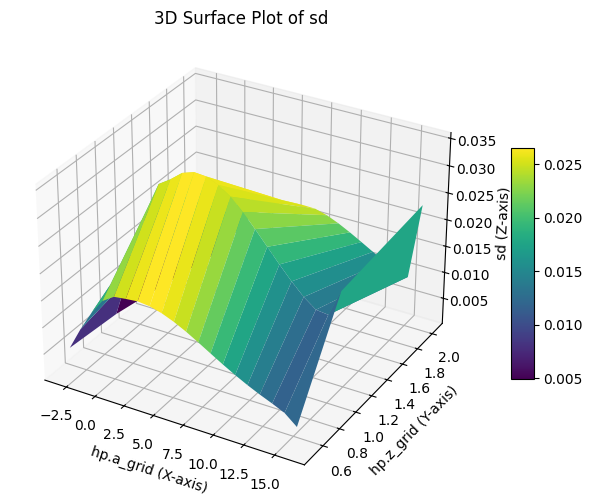

In [123]:
# 定常分布 sd のプロット
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# メッシュグリッドを作成
X, Y = np.meshgrid(hp.a_grid, hp.z_grid)
Z = sd.T  # データの形状を合わせるため転置（必要なら）

# 3Dプロット
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# 軸ラベル
ax.set_xlabel('hp.a_grid (X-axis)')
ax.set_ylabel('hp.z_grid (Y-axis)')
ax.set_zlabel('sd (Z-axis)')
ax.set_title('3D Surface Plot of sd')

plt.show()

# 12/6の勉強会のコード

In [ ]:
#### 12/06勉強会でのコード

pf = np.zeros((hfun_c.shape[0], hfun_c.shape[1]))
for i in range(hfun_c.shape[0]):
  for j in range(hfun_c.shape[1]):
    pf[i,j] = hp.R * hp.a_grid[i] + hp.z_grid[j] - hfun_c[i,j]


a_grid = hp.a_grid
p = hp.Pz
a_min = -hp.b
a_max = 16


# グリッド設定
m = pf.shape[0]  # 内生的状態変数aのグリッド数 (a1, a2, a3)
n = pf.shape[1]  # 外生的状態変数yのグリッド数 (y_H, y_L)
epsilon = 1e-5  # 収束基準


# 初期分布 f^{(0)}_{i,j}
f = np.full(pf.shape, 1/pf.size)
# f = f.T
# f= f.reshape(6, 1)

f_new = np.zeros((m, n))
#for j in range(n):  #次期のyのindexについて繰り返し
# pf_t = pf.T
# target_a = pf_t.reshape(6, 1)  # 政策関数による次期a



# 定常分布の計算ループ
max_diff = epsilon + 1  # 初期化: epsilon より大きくしてループを開始
iteration = 0

while max_diff >= epsilon:
    f_new = np.zeros((m, n))
    # pf_t = pf.T
    # target_a = pf_t.reshape(6, 1)  # 政策関数による次期a

    for j in range(n):  #今期のyのindexについて繰り返し
        for i in range(m): #今期のaのindexについて繰り返し


          aprime = pf[i,j]

          for k in range(n): #来期のyのindexについて繰り返し

            if aprime <= a_min:
                f_new[0,k] = f_new[0,k] + f[i,j]*p[j,k]
            elif aprime >= a_max:
                f_new[m-1,k] = f_new[m-1,k] + f[i,j]*p[j,k]
            elif (aprime>a_min) and (aprime<a_max):
                l = sum(a_grid<=aprime)
                weight = (aprime-a_grid[l-1]) / (a_grid[l]-a_grid[l-1])
                f_new[l,k] = f_new[l,k] + weight*f[i,j]*p[j,k]
                f_new[l-1,k] =f_new[l-1,k] + (1-weight)*f[i,j]*p[j,k]



    # 収束の確認
    max_diff = np.max(np.abs(f_new - f))
    print(f"Iteration {iteration + 1}: max difference = {max_diff}")

    # 更新
    f = f_new
    iteration += 1

# 最終イタレーション回数の出力
print(f"Total iterations until convergence: {iteration}")

# 定常分布の出力
print("Stationary distribution f_{i,j}:")
print(f)


Iteration 1: max difference = 0.003447920894973263
Iteration 2: max difference = 0.002601471123817728
Iteration 3: max difference = 0.0018858240100315723
Iteration 4: max difference = 0.0011986996381739392
Iteration 5: max difference = 0.0008224407268961403
Iteration 6: max difference = 0.0006001964445547002
Iteration 7: max difference = 0.0004335915398395729
Iteration 8: max difference = 0.00031013921340649654
Iteration 9: max difference = 0.00021950349360230163
Iteration 10: max difference = 0.00024176523163877035
Iteration 11: max difference = 0.00024918806378158853
Iteration 12: max difference = 0.00025769894539354535
Iteration 13: max difference = 0.0002600614089616621
Iteration 14: max difference = 0.0002563801053594456
Iteration 15: max difference = 0.0002539643304503899
Iteration 16: max difference = 0.00024879907132024405
Iteration 17: max difference = 0.00024247934750921962
Iteration 18: max difference = 0.00023677324301961053
Iteration 19: max difference = 0.0002300166150550

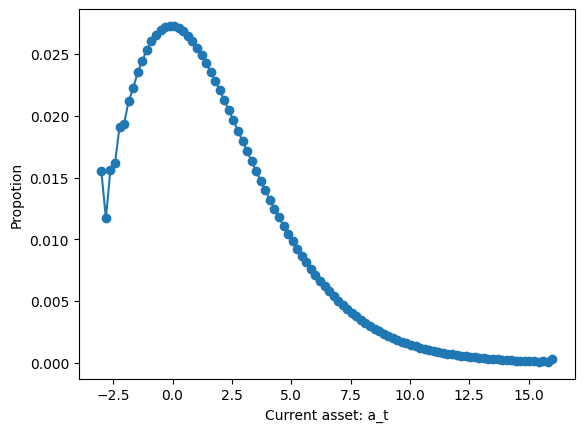

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 消費の政策関数をプロット
df = pd.DataFrame({
    'x_axis': hp.a_grid,
    'y_axis': np.sum(f,axis=1)})
# plot
plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o')
plt.xlabel('Current asset: a_t')
plt.ylabel('Propotion')
# plt.legend([""])
plt.show()

In [ ]:
for l in range(2):     # iteration over employment types in period t
    # prepare interpolation of optimal next-period asset policy
    aopt_polate = interpolate.interp1d(a_grid_pf,pf[:,l])
    for i in range(nk):  # iteration over assets in period t
        if k1 <= amin:
            gk[0,0] = gk[0,0] + gk0[i,l]*prob[l,0]
            gk[0,1]= gk[0,1] + gk0[i,l]*prob[l,1]
        elif k1 >= amax:
            gk[nk-1,0] = gk[nk-1,0] + gk0[i,l]*prob[l,0]
            gk[nk-1,1] = gk[nk-1,1] + gk0[i,l]*prob[l,1]
        elif (k1>amin) and (k1<amax):
            j = sum(a_grid<=k1) # k1 lies between ag[j-1] and ag[j]
            n0 = (k1-a_grid[j-1]) / (a_grid[j]-a_grid[j-1])
            gk[j,0] = gk[j,0] + n0*gk0[i,l]*prob[l,0]
            gk[j,1] = gk[j,1] + n0*gk0[i,l]*prob[l,1]
            gk[j-1,0] =gk[j-1,0] + (1-n0)*gk0[i,l]*prob[l,0]
            gk[j-1,1] =gk[j-1,1] + (1-n0)*gk0[i,l]*prob[l,1]

In [ ]:
import numpy as np

pf_grid = np.array([[20, -48], [32, 15], [144, 27]])
a_grid = np.array([12, 24, 36])
sd_grid = np.full((3, 2), 1/6)
Pmatrix = np.array([[0.9, 0.1], [0.1, 0.9]])

solve_stationary_dist(pf_grid, a_grid, sd_grid, Pmatrix)

Iteration 1: diff = <object type:float64>
Iteration 2: diff = <object type:float64>
Iteration 3: diff = <object type:float64>
Iteration 4: diff = <object type:float64>
Iteration 5: diff = <object type:float64>
Iteration 6: diff = <object type:float64>
Iteration 7: diff = <object type:float64>
Iteration 8: diff = <object type:float64>
Iteration 9: diff = <object type:float64>
Iteration 10: diff = <object type:float64>
Iteration 11: diff = <object type:float64>
Iteration 12: diff = <object type:float64>
Iteration 13: diff = <object type:float64>
Iteration 14: diff = <object type:float64>
Iteration 15: diff = <object type:float64>
Iteration 16: diff = <object type:float64>
Iteration 17: diff = <object type:float64>
Iteration 18: diff = <object type:float64>
Iteration 19: diff = <object type:float64>
Iteration 20: diff = <object type:float64>
Iteration 21: diff = <object type:float64>
Iteration 22: diff = <object type:float64>
Iteration 23: diff = <object type:float64>
Iteration 24: diff =

array([[1.46285425e+113, 9.45038937e+277],
       [1.46285425e+113, 2.28001367e+087],
       [9.45038937e+277, 2.28001367e+087]])

In [ ]:
import numpy as np

pf_grid = hfun_c
a_grid = hp.a_grid
sd_grid = np.full(pf_grid.shape, 1/pf_grid.size)
Pmatrix = hp.Pz

import time

start = time.perf_counter() #計測開始

test = solve_stationary_dist(pf_grid, a_grid, sd_grid, Pmatrix)

end = time.perf_counter() #計測終了
print('{:.2f}'.format((end-start)/60)) # 87.97(秒→分に直し、小数点以下の桁数を指定して出力)

Iteration 1: diff = <object type:float64>
Iteration 2: diff = <object type:float64>
Iteration 3: diff = <object type:float64>
Iteration 4: diff = <object type:float64>
Iteration 5: diff = <object type:float64>
Iteration 6: diff = <object type:float64>
Iteration 7: diff = <object type:float64>
Iteration 8: diff = <object type:float64>
Iteration 9: diff = <object type:float64>
Iteration 10: diff = <object type:float64>
Iteration 11: diff = <object type:float64>
Iteration 12: diff = <object type:float64>
Iteration 13: diff = <object type:float64>
Iteration 14: diff = <object type:float64>
Iteration 15: diff = <object type:float64>
Iteration 16: diff = <object type:float64>
Iteration 17: diff = <object type:float64>
Iteration 18: diff = <object type:float64>
Iteration 19: diff = <object type:float64>
Iteration 20: diff = <object type:float64>
Iteration 21: diff = <object type:float64>
Iteration 22: diff = <object type:float64>
Iteration 23: diff = <object type:float64>
Iteration 24: diff =

In [ ]:
nk = 3



# Step: initialization of the distribution functions */

# Variant 1: uniform distribution
gk = np.ones((nk,2))/nk
gk = gk * np.transpose(pp1)
gk

array([[0.04703448, 0.28629886],
       [0.04703448, 0.28629886],
       [0.04703448, 0.28629886]])

In [ ]:
nk = 3



# Step: initialization of the distribution functions */

# Variant 1: uniform distribution
gk = np.ones((nk,2))/nk
gk = gk * np.transpose(pp1)

# # Variant 2: equal distribution, all hold KK0
# gk = np.zeros((nk,2))
# gk[nk0,0] = pp1[0]
# gk[nk0,1] = pp1[1]


gk0 = gk+0             # distribution in period t
gk = np.zeros((nk,2))    # distribution in period t+1

for l in range(2):     # iteration over employment types in period t
    # prepare interpolation of optimal next-period asset policy
    aopt_polate = interpolate.interp1d(a_grid_pf,pf[:,l])
    for i in range(nk):  # iteration over assets in period t
        k0 = a_grid[i]  #a_grid_pfとa_gridは一般に異なるかもしれないので、pfのinterpolationをする必要がある
        if k0 <= amin:
            k1 = pf[0,l]
        elif k0 >= amax:
          k1=pf[na-1,l]
        else:
          k1 = aopt_polate(k0) # linear interpolation for a'(a)

        if k1 <= amin:
            gk[0,0] = gk[0,0] + gk0[i,l]*prob[l,0]
            gk[0,1]= gk[0,1] + gk0[i,l]*prob[l,1]
        elif k1 >= amax:
            gk[nk-1,0] = gk[nk-1,0] + gk0[i,l]*prob[l,0]
            gk[nk-1,1] = gk[nk-1,1] + gk0[i,l]*prob[l,1]
        elif (k1>amin) and (k1<amax):
            j = sum(a_grid<=k1) # k1 lies between ag[j-1] and ag[j]
            n0 = (k1-a_grid[j-1]) / (a_grid[j]-a_grid[j-1])
            gk[j,0] = gk[j,0] + n0*gk0[i,l]*prob[l,0]
            gk[j,1] = gk[j,1] + n0*gk0[i,l]*prob[l,1]
            gk[j-1,0] =gk[j-1,0] + (1-n0)*gk0[i,l]*prob[l,0]
            gk[j-1,1] =gk[j-1,1] + (1-n0)*gk0[i,l]*prob[l,1]

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 4 11:16:54 2020


author: Burkhard Heer

book: Dynamic General Equilibrium Modeling: Computational
        Methods and Applications, with Alfred Maussner

Chapter 8.2., distribution function

Algorithm 8.2.3 in Heer/Maussner (2023)

computation of the policy functions and the distribution function
in the heterogenous-agent neoclassical growth model
with value function iteration

Linear interpolation between grid points

Maximization of value function: golden section search method


"""

# Part 1: import libraries
import numpy as np
from scipy.linalg import inv
from scipy import interpolate
import time
import matplotlib.pyplot as plt
import math

log = math.log

# Part 2: functions
# equivec1 computes the ergodic distribution
# see pages 654-656 in Heer/Maussner (2009)
# on DSGE modeling, 2nd edition
def equivec1(p):
    nrows,ncols = p.shape
    for i in range(nrows):
        p[i,i] = p[i,i]-1

    q = p[:,0:nrows-1]
    # appends column vector
    q = np.c_[q,np.ones(nrows)]
    x = np.zeros(nrows-1)
    # appends element in row vector
    x = np.r_[x,1]
    y =  np.transpose(x) @ inv(q)
    return np.transpose(y)


#
# wage function
def wage_rate(k,l):
    return (1-alpha) * k**alpha * l**(-alpha)

# interest rate function
def interest_rate(k,l):
    return alpha * k**(alpha - 1) * l**(1-alpha) - delta


# utility function
def utility(x):
    if sigma==1:
        return  log(x)
    else:
        return x**(1-sigma) / (1-sigma)


# right-hand-side of the Bellman equation
# input:
# a0 - wealth a in period t
# a1 - wealth a' in period t+1
# y - employment status in period t
# output:
# rhs of Bellman eq.
def bellman(a0,a1,y):
   if y==0:     # y=0: employed, y=1: unemployed
      c = (1+(1-tau)*r) * a0 + (1-tau)*w - a1
   else:
       c = (1+(1-tau)*r)*a0 + b - a1

   if c<0:
      return negvalue

   if a1>amax:
      return a1**2*negvalue

   # output: right-hand side of the Bellman equation
   return utility(c) + beta*(prob[y,0]*value(a1,0) + prob[y,1]*value(a1,1))



# value interpolates value function vold[a,e] at a
def value(x,y):
    if y==0:
        return ve_polate(x)
    else:
        return vu_polate(x)


# value1 rewrites the Bellman function
# as a function of one variable x=a', the next-period asset level
# for given present period assets a[i] and employment status e
# -> function in one argument x necessary for applying
# Golden Section Search
def value1(x):
    return bellman(ainit,x,e)

# searches the MAXIMUM using golden section search
# see also Chapter 11.6.1 in Heer/Maussner, 2009,
# Dynamic General Equilibrium Modeling: Computational
# Methods and Applications, 2nd ed. (or later)
def GoldenSectionMax(f,ay,by,cy,tol):
    r1 = 0.61803399
    r2 = 1-r1
    x0 = ay
    x3 = cy
    if abs(cy-by) <= abs(by-ay):
        x1 = by
        x2 = by + r2 * (cy-by)
    else:
        x2 = by
        x1 = by - r2 * (by-ay)

    f1 = - f(x1)
    f2 = - f(x2)

    while abs(x3-x0) > tol*(abs(x1)+abs(x2)):
        if f2<f1:
            x0 = x1
            x1 = x2
            x2 = r1*x1+r2*x3
            f1 = f2
            f2 = -f(x2)
        else:
            x3 = x2
            x2 = x1
            x1 = r1*x2+r2*x0
            f2 = f1
            f1 = -f(x1)

    if f1 <= f2:
        xmin = x1
    else:
        xmin = x2

    return xmin

def testfunc(x):
    return -x**2 + 4*x + 6

# test goldensectionsearch
xmax = GoldenSectionMax(testfunc,-2.2,0.0,10.0,0.001)
print(xmax)

start_time = time.time()

# Part 3: Numerical parameters
tol = 0.001             # stopping criterion for final solution of K
tol1 = 1e-7             # stopping criterion for golden section search
tolg = 0.0000001        # stopping criterion for distribution function
negvalue = -1e10             # initialization for the value function
eps = 0.05              # minimum distance between grid point amin and amin+varepsilon
                         # in order to check if amin is binding lower bound
nit = 100                # maximum number of maximum iterations over value function
ngk = 0                  # initial number of iterations over distribution function
crit1 = 1 + tol          # percentage deviation in the iteration over the aggregate capital stock
critg = 1 + tol          # deviation of two successive solutions for distribution function:
                         # kritg=sumc(abs(gk0-gk));
nq = 70                  # maximum number of iterations over K, outer loop

psi1 = 0.95              # linear update of K and tau in the outer loop
                         # K^{i+1} = psi1 * K^i + (1-psi1) * K^{i*}, where K^{i*} new solution in iteration i
kbarq = np.zeros(nq)
k1barq = np.zeros(nq)           # convergence of kk1 ?
kritvq = np.zeros(nq)       # convergence of value function
crit = 1+tol                    # error in value function: crit=meanc(abs(vold-v));


# Part 4: Parameterization of the model
alpha = 0.36
beta = 0.995
delta = 0.005
sigma = 2
tau = 0.02
r = 0.005
rep = 0.25
pp0 = np.array([[0.9565,0.0435],[0.5,0.5]]) # for the computaton of the
                                            # ergodic distribution
prob = pp0 + 0  # entries are the same as in pp0



# asset grid: Value function
amin = -2               # lower bound asset grid over value function
amax = 3000             # upper bound
na = 201                 # number of equispaced points
a =  np.linspace(amin, amax, na)   # asset grid


# asset grid: Distribution function: Step 5.1 from Algorithm 7.2.2
nk = 3*na            # number of asset grid points over distribution
nk = na
ag =  np.linspace(amin, amax, nk)   # asset grid for distribution function

# initialization distribution function
gk = np.zeros((nk,2))

# Part 5: Computation of the
# stationary employment /unemployment
# with the help of the ergodic distribution
print(prob)
pp1 = equivec1(pp0)
nn0 = pp1[0] # measure of employed households in economy
print(pp1)
print(prob)

# Part 6: Initial guess K and tau
kk0 = (alpha/(1/beta-1+delta))**(1/(1-alpha))*nn0

# Compute w and r and b
w0 = wage_rate(kk0,nn0)
r0 = interest_rate(kk0, nn0)
b = w0*rep  # unemployment insurance


# Part 7:
# initialization of the value function, consumption and next-period asset
#              policy functions
# assumption: employed/unemployed consumes his income permanently

ve = utility( (1-tau)*r*a+(1-tau)*w0) # utility of the employed with asset a
vu = utility( (1-tau)*r*a+b )    # utility of the unemployed with asset a
v =   np.c_[ve,vu]
v = v/(1-beta)                  # agents consume their income
copt = np.zeros((na,2))         # optimal consumption
aopt = np.zeros((na,2))         # optimal next-period assets

kk1 = kk0-1                  # initialization so that kk1 \ne kk0


nk0 = sum(ag<=kk0)              # asset grid point ag[nk0] is chosen as initial distribution
                                # => all households hold capital stock kk0

# outer loop over aggregate capital stock K
q = -1
while q<nq-1  and (crit1>tol or ngk<25000):    # iteration over K
    q = q+1
    w = wage_rate(kk0,nn0)
    r = interest_rate(kk0, nn0)

    kbarq[q] = kk0 # saving aggregate capital stock in iteration q

    # slow increment of the number of iterations over distribution
    # gk, corresponding to the number of iteration i over f_i in the textbook
    if ngk<25000:
        ngk = ngk+500

    # mean wealth during iteration over f_i for given w, r and b
    kt = np.zeros(ngk)

    # incremental increase in number of iterations over value functions
    nit=nit+2

    # loop over value function
    crit=1+tol
    j = -1
    while j<=50 or (j<nit-1 and crit>tol):
        j=j+1

        vold = v + 0
        # prepare interpolation in value1()
        ve_polate = interpolate.interp1d(a,vold[:,0])
        vu_polate = interpolate.interp1d(a,vold[:,1])
        #print("iteration j~q: " + str([j,q]))
        #print("kk0~kk1 " + str([kk0,kk1]) )
        #sec = (time.time() - start_time)
        #ty_res = time.gmtime(sec)
        #res = time.strftime("%H : %M : %S", ty_res)
        #print(res)
        #print("error value function: " + str(crit) )
        #print("error k: " + str(crit1) )
        #print("error distribution function: " + str(critg))

        # ----------------------------------------------------------------
        #
        # Step: Compute the household's decision function
        #        Iteration of the value function
        #
        # -----------------------------------------------------------------

        # iteration over the employment status
        # e=0 employed, e=1 unemployed

        for e in range(2):
            l0 = -1  # initialization of a'
                    # exploiting monotonocity of a'(a)
            # iteration over the asset grid a = a_1,...a_na
            for i in range(na):
                ainit = a[i]
                l = l0
                v0 = negvalue
                # iteration over a' to bracket the maximum of
                # the rhs of the Bellman equation,
                # ax < bx < cx and a' is between ax and cx

                ax = a[0]
                bx = a[0]
                cx = amax

                while l<na-1:
                    l = l+1
                    if e==0:
                        c0 = (1+(1-tau)*r) * ainit + (1-tau)*w - a[l]
                    else:
                        c0 = (1+(1-tau)*r) * ainit + b - a[l]


                    if c0>0:
                        v1 = bellman(ainit,a[l],e)
                        if v1>v0:
                            v[i,e] = v1
                            if l==0:
                               ax=a[0]
                               bx=a[0]
                               cx=a[1]
                            elif l==na-1:
                                ax=a[na-2]
                                bx=a[na-1]
                                cx=a[na-1]
                            else:
                                ax=a[l-1]
                                bx=a[l]
                                cx=a[l+1]

                            v0=v1
                            l0=l-1
                        else:
                            l=na-1   # concavity of value function

                    else:
                        l=na-1


                if ax==bx:  # boundary optimum, ax=bx=a[1]
                    bx = ax+eps*(a[1]-a[0])
                    if value(bx,e)<value(ax,e):
                        aopt[i,e] = a[0]
                    else:
                        aopt[i,e] = GoldenSectionMax(value1,ax,bx,cx,tol1)
                elif bx==cx:  # boundary optimum, bx=cx=a[na-1]
                    bx = cx-eps*(a[na-1]-a[na-2])
                    if value(bx,e)<value(cx,e):
                        aopt[i,e] = a[na-1]
                    else:
                        aopt[i,e] = GoldenSectionMax(value1,ax,bx,cx,tol1)

                else:
                    aopt[i,e] = GoldenSectionMax(value1,ax,bx,cx,tol1)

                v[i,e] = bellman(a[i],aopt[i,e],e)

        x = abs(vold-v)
        crit = x.mean(0)  # mean of the columns, value functions of employed
                          # and unemployd
        crit = max(crit)

    if q==0: # plotting the value and policy function
        fig, ax = plt.subplots()
        label1 = 'employed'
        label2 = 'unemployed'
        ax.plot(a,v[:,0], linewidth=2, label=label1)
        ax.plot(a,v[:,1], linewidth=2, label=label2)
        ax.legend()
        plt.show()

    # iteration over value function complete
    copt[:,0] = (1+(1-tau)*r)*a + (1-tau)*w - aopt[:,0]
    copt[:,1] = (1+(1-tau)*r)*a + b - aopt[:,1]
    kritvq[q] = crit

    # iteration to find invariant distribution */

    kritg = 1+tol
    kconv = np.zeros(ngk+1) # convergence criterion
    # Step: initialization of the distribution functions */

    # Variant 1: uniform distribution
    #    gk = np.ones((nk,2))/nk
    #    gk = gk * np.transpose(pp1)
    #
    # Variant 2: equal distribution, all hold KK0
    gk = np.zeros((nk,2))
    gk[nk0,0] = pp1[0]
    gk[nk0,1] = pp1[1]

    for q1 in range(ngk):   # iteration over periods (dynamics of distribution)
         gk0 = gk+0             # distribution in period t
         gk = np.zeros((nk,2))    # distribution in period t+1

         for l in range(2):     # iteration over employment types in period t
             # prepare interpolation of optimal next-period asset policy
             aopt_polate = interpolate.interp1d(a,aopt[:,l])
             for i in range(nk):  # iteration over assets in period t
                 k0 = ag[i]
                 if k0 <= amin:
                     k1 = aopt[0,l]
                 elif k0 >= amax:
                    k1=aopt[na-1,l]
                 else:
                    k1 = aopt_polate(k0) # linear interpolation for a'(a)

                 if k1 <= amin:
                     gk[0,0] = gk[0,0] + gk0[i,l]*prob[l,0]
                     gk[0,1]= gk[0,1] + gk0[i,l]*prob[l,1]
                 elif k1 >= amax:
                     gk[nk-1,0] = gk[nk-1,0] + gk0[i,l]*prob[l,0]
                     gk[nk-1,1] = gk[nk-1,1] + gk0[i,l]*prob[l,1]
                 elif (k1>amin) and (k1<amax):
                     j = sum(ag<=k1) # k1 lies between ag[j-1] and ag[j]
                     n0 = (k1-ag[j-1]) / (ag[j]-ag[j-1])
                     gk[j,0] = gk[j,0] + n0*gk0[i,l]*prob[l,0]
                     gk[j,1] = gk[j,1] + n0*gk0[i,l]*prob[l,1]
                     gk[j-1,0] =gk[j-1,0] + (1-n0)*gk0[i,l]*prob[l,0]
                     gk[j-1,1] =gk[j-1,1] + (1-n0)*gk0[i,l]*prob[l,1]

         gk=gk/sum(sum(gk))
         kk1 = np.transpose(gk[:,0]+gk[:,1]) @ ag # new mean capital stock
         critg=sum(sum(abs(gk0-gk)))
         kconv[q1] = critg
         kt[q1] = kk1

    if q==0: # plotting the value and policy function
        fig, ax = plt.subplots()
        label1 = 'employed'
        label2 = 'unemployed'
        ax.plot(ag[0:200],gk[0:200,0], linewidth=2, label=label1)
        ax.plot(ag[0:200],gk[0:200,1], linewidth=2, label=label2)
        ax.legend()
        plt.show()



    crit1 = abs((kk1-kk0)/kk0)   # end outer loop over K, q=1,..

    print("kk0~kk1: " + str([kk0,kk1]) )
    print("outer iteration q: " + str(q))
    print("crit value fucntion: " +str(crit))
    print("crit K: " +str(crit1))
    print("crit distribution: " + str(critg))
    sec = (time.time() - start_time)
    ty_res = time.gmtime(sec)
    res = time.strftime("%H : %M : %S", ty_res)
    print(res)

    kk0 = psi1*kk0+(1-psi1)*kk1
    tau = b*pp1[1]/(w*nn0+r*kk0)


k1barq[q] = kk1
print("kk0~kk1 " + str([kk0,kk1]) )
sec = (time.time() - start_time)
ty_res = time.gmtime(sec)
res = time.strftime("%H : %M : %S", ty_res)
print(res)
print("error value function: " + str(crit) )
print("error k: " + str(crit1) )
print("error distribution function: " + str(critg))


plt.plot(kbarq)
plt.show()


plt.plot(kt)
plt.show()